In [47]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



data\BB_Rates_15min_from_10-2023.xlsx


In [48]:
import torch.nn as nn
import pandas as pd
import numpy as np
from matplotlib import pyplot
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns 
file_path = 'data\BB_Rates_15min_from_10-2023.xlsx'
data = pd.read_excel(file_path)


In [49]:
start_index = 3
EURUSD = data.iloc[start_index:, :2]

# Rename the columns
EURUSD.columns = ['Dates', 'Close']

# Display the first few rows of the new dataset to verify
print(EURUSD.tail())

                     Dates   Close
13539  2024-04-17 09:30:00  1.0632
13540  2024-04-17 09:45:00  1.0625
13541  2024-04-17 10:00:00   1.063
13542  2024-04-17 10:15:00  1.0642
13543  2024-04-17 10:30:00  1.0647


In [50]:
# Convertiere 'Dates' spalte zu Datetime format
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])
#EURUSD.head()


In [51]:
EURUSD['Dates'] = pd.to_datetime(EURUSD['Dates'])

# Extrahieren aller Datenpunkte, die zum 4. Oktober 2023 gehören
subset = EURUSD[EURUSD['Dates'].dt.date == pd.to_datetime('2023-10-04').date()]

In [52]:
days_full = pd.DataFrame(EURUSD)

In [53]:
days_full['Dates'] = pd.to_datetime(days_full['Dates'])

In [54]:
## Daten in datetime-date objekt umwandeln und dann gruppieren
days_full['Dates'] = days_full['Dates'].dt.date
entries_per_day = days_full.groupby('Dates').size()
full_days = entries_per_day[entries_per_day == 96].index
print(full_days)

Index([2023-10-04, 2023-10-05, 2023-10-09, 2023-10-10, 2023-10-11, 2023-10-12,
       2023-10-16, 2023-10-17, 2023-10-18, 2023-10-19,
       ...
       2024-04-01, 2024-04-02, 2024-04-03, 2024-04-04, 2024-04-08, 2024-04-09,
       2024-04-10, 2024-04-11, 2024-04-15, 2024-04-16],
      dtype='object', name='Dates', length=109)


In [55]:

full_days_df = days_full[days_full['Dates'].isin(full_days)]

print(len(full_days_df))

10464


In [56]:
daily_series = []

# Iteriert über volle Tage und extrahiert die Zeitreihen
for day in full_days:
    daily_data = full_days_df[full_days_df['Dates'] == day]['Close'].values
    daily_series.append(daily_data)
daily_series_array = np.array(daily_series, dtype=np.float32)
print(daily_series_array)
# datetimes als index gesetzt macht paar Sachen einfacher
full_days_df = full_days_df.set_index('Dates')

[[1.0468 1.0467 1.0467 ... 1.0506 1.0506 1.0507]
 [1.0508 1.0508 1.0506 ... 1.0549 1.0549 1.0549]
 [1.0552 1.0552 1.0555 ... 1.0566 1.0566 1.0566]
 ...
 [1.0741 1.0743 1.0743 ... 1.0727 1.0728 1.0727]
 [1.0642 1.0648 1.0651 ... 1.0625 1.0625 1.0625]
 [1.0626 1.0627 1.0627 ... 1.0618 1.0617 1.0617]]


In [57]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # werden als MSE über alle elemente und batch summiert
    mse_loss = nn.MSELoss(reduction = 'sum')(recon_x, x)

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = 1/2*torch.sum(1+logvar -mu.pow(2) - logvar.exp())

    total_loss = mse_loss - kld_loss

    return total_loss, mse_loss, kld_loss

In [73]:
from sklearn.preprocessing import MinMaxScaler

# Daten extrahieren
data = daily_series_array

# Normalisierung
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Aktualisierung der Daten in der DataFrame

In [75]:
dataset = torch.tensor(normalized_data) 
train_size = int(0.8*len(dataset))
test_size = len(dataset)-train_size
print(train_size)
print(test_size)
train_data, test_data = train_test_split(dataset, test_size=test_size, random_state=42)
train_data = train_data.unsqueeze(-1)
test_data = test_data = test_data.unsqueeze(-1)
train_data.shape

87
22


torch.Size([87, 96, 1])

In [76]:
print(dataset)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0625, 0.0638, 0.0607,  ..., 0.0720, 0.0720, 0.0701],
        [0.1313, 0.1322, 0.1371,  ..., 0.1005, 0.1005, 0.0985],
        ...,
        [0.4266, 0.4292, 0.4299,  ..., 0.3702, 0.3719, 0.3673],
        [0.2719, 0.2815, 0.2866,  ..., 0.1993, 0.1993, 0.1970],
        [0.2469, 0.2488, 0.2492,  ..., 0.1876, 0.1859, 0.1836]])


In [77]:
batch_size = 16
train_loader  = torch.utils.data.DataLoader(train_data, batch_size= batch_size, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_data, batch_size= batch_size, shuffle=True)

In [79]:
learning_rate= 0.001
input_size = 1
hidden_size = 96
latent_space_dim = 96
num_layers = 2
epochs = 70

In [80]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(EncoderLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        _, (h_n, c_n) = self.lstm(x)
        # h_n: (num_layers, batch_size, hidden_size)
        # c_n: (num_layers, batch_size, hidden_size)
        return h_n, c_n
        
class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DecoderLSTM, self).__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, h_n, c_n):
        # x: (batch_size, seq_len, input_size)
        # h_n: (num_layers, batch_size, hidden_size)
        # c_n: (num_layers, batch_size, hidden_size)
        output, _ = self.lstm(x, (h_n, c_n))
        # output: (batch_size, seq_len, hidden_size)
        output = self.fc(output)
        # output: (batch_size, seq_len, output_size)
        return output
class VAE_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_space_dim, num_layers):
        super(VAE_LSTM, self).__init__()
        
        self.encoder = EncoderLSTM(input_size, hidden_size, num_layers)
        
        self.mu_layer = nn.Linear(hidden_size, latent_space_dim)
        self.logvar_layer = nn.Linear(hidden_size, latent_space_dim)
        
        self.z_layer = nn.Linear(latent_space_dim, hidden_size)
        
        self.decoder = DecoderLSTM(latent_space_dim, hidden_size, num_layers, input_size)
            
    def forward(self, x):
        h_n, c_n = self.encoder(x)
        
        mu = self.mu_layer(h_n[-1])  # Verwende den letzten hidden state als Eingabe für mu und logvar
        logvar = self.logvar_layer(h_n[-1])
        
        if self.training:
            sigma = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(sigma)
            z = mu + epsilon * sigma
        else:
            z = mu
        
        z = self.z_layer(z)
        z = z.unsqueeze(1).repeat(1, x.size(1), 1)  # Wiederhole z für jede Zeitschritt
        output = self.decoder(z, h_n, c_n)
        
        return output, mu, logvar

In [81]:
class VAE_LSTM_V2(nn.Module):
    def __init__(self, input_size, hidden_size, latent_space_dim, num_layers):
        super(VAE_LSTM, self).__init__()
        
        self.encoder = EncoderLSTM(input_size, hidden_size, num_layers)
        
        self.mu_layer = nn.Linear(hidden_size, latent_space_dim)
        self.logvar_layer = nn.Linear(hidden_size, latent_space_dim)
        
        self.z_layer = nn.Linear(latent_space_dim, hidden_size)
        
        self.decoder = DecoderLSTM(latent_space_dim, hidden_size, num_layers, input_size)
            
    def forward(self, x):
        h_n, c_n = self.encoder(x)
        
        mu = self.mu_layer(h_n[-1])  # Verwende den letzten hidden state als Eingabe für mu und logvar
        logvar = self.logvar_layer(h_n[-1])
        
        if self.training:
            sigma = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(sigma)
            z = mu + epsilon * sigma
        else:
            z = mu
        
        z = self.z_layer(z)
        z = z.unsqueeze(1).repeat(1, x.size(1), 1)  # Wiederhole z für jede Zeitschritt
        output = self.decoder(z, h_n, c_n)
        
        return output, mu, logvar
    
    def predict_future(self, x, future_steps):
        h_n, c_n = self.encoder(x)
    
    # latentn Variablen mu und logvar
        mu = self.mu_layer(h_n[-1])
        logvar = self.logvar_layer(h_n[-1])
    
    #Reparametrisierungstrick
        if self.training:
            sigma = torch.exp(0.5 * logvar)
            epsilon = torch.randn_like(sigma)
            z = mu + epsilon * sigma
        else:
            z = mu
    
    # Transformieren latenten Variable z
        z = self.z_layer(z)
        z = z.unsqueeze(1).repeat(1, future_steps, 1)  # Wiederhole z für jede zukünftige Zeitschritt
    
    # Prediction
        future_output = self.decoder(z, h_n, c_n)
    
        return future_output


In [82]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction losses are calculated using Mean Squared Error (MSE) and 
    # summed over all elements and batch
    mse_loss = nn.MSELoss(reduction = 'sum')(recon_x, x)

    # See Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    kld_loss = 1/2*torch.sum(1+logvar -mu.pow(2) - logvar.exp())

    total_loss = mse_loss - kld_loss

    return total_loss, mse_loss, kld_loss

In [95]:
learning_rate= 0.001
input_size = 1
hidden_size = 16
latent_space_dim = 16
num_layers = 3
epochs = 300



In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE_LSTM(input_size,hidden_size, latent_space_dim, num_layers)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [85]:
import time
import numpy as np
import torch
import fastprogress

def train(train_loader, optimizer, model, loss_fn, master_bar):
    total_loss = 0
    mse_loss = 0
    kl_loss = 0.
    
    for data in fastprogress.progress_bar(train_loader, parent=master_bar):
        model.train()
        inputs = data
      
       
       # print(type(inputs[0]))
        inputs = [tensor.to(device) for tensor in data]
        inputs = torch.stack(inputs).squeeze(0).float()
        #print(inputs.shape)
        #print(inputs.size())
        optimizer.zero_grad()
        
        pred, mu, logvar = model(inputs)
        
        t_loss, m_loss, k_loss = loss_fn(pred, inputs, mu, logvar)
        t_loss.backward()
        optimizer.step()
        
        total_loss += t_loss.item()
        mse_loss += m_loss.item()
        kl_loss += k_loss.item()
        
    return total_loss, mse_loss, kl_loss

def test_set_loss(test_dataloader, model, loss_function, master_bar):
    total_loss = 0
    mse_loss = 0
    kl_loss = 0.
    
    with torch.no_grad():
        for data in fastprogress.progress_bar(test_dataloader, parent=master_bar):
            model.eval()
            inputs = [tensor.to(device) for tensor in data]
            inputs = torch.stack(inputs).squeeze(0).float()
        
            #inputs = inputs.to(device)
            #inputs = [tensor.to(device) for tensor in inputs]
           #print(inputs.size())
            pred, mu, logvar = model(inputs)

            t_loss, m_loss, k_loss = loss_function(pred, inputs, mu, logvar)

            total_loss += t_loss.item()
            mse_loss += m_loss.item()
            kl_loss += k_loss.item()

    return total_loss, mse_loss, kl_loss

def run_training(model, optimizer, loss_function, num_epochs, 
                 train_dataloader, test_dataloader, verbose=False):
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    total_losses, mse_losses, kl_losses = [], [], []
    test_total_losses, test_mse_losses, test_kl_losses = [], [], []

    for epoch in master_bar:
        # Train the model
        total_loss, mse_loss, kl_loss = train(train_dataloader, optimizer, model, 
                                              loss_function, master_bar)

        # Test the model
        test_total_loss, test_mse_loss, test_kl_loss = test_set_loss(test_dataloader, model, 
                                                                     loss_function, master_bar)

        # Save loss for plotting
        total_losses.append(total_loss)
        mse_losses.append(mse_loss)
        kl_losses.append(kl_loss)
        
        test_total_losses.append(test_total_loss)
        test_mse_losses.append(test_mse_loss)
        test_kl_losses.append(test_kl_loss)
        
        if verbose:
            master_bar.write(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss:.4f}, Test Loss: {test_total_loss:.4f}')

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    
    return total_losses, mse_losses, kl_losses, test_total_losses, test_mse_losses, test_kl_losses



In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
total_losses, mse_losses, kl_losses, test_total_losses, test_mse_losses, test_kl_losses = run_training(
        model, torch.optim.Adam(model.parameters(), lr=learning_rate), vae_loss, epochs, train_loader, test_loader)


Finished training after 322 seconds.


In [ ]:
import matplotlib.pyplot as plt

In [87]:

def plot(title, label, train_results, val_results, yscale='linear', save_path=None, 
         extra_pt=None, extra_pt_label=None):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training "+label.lower(), "Test "+label.lower()
    
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'test results']
    
    if extra_pt:
        ####################
        ## YOUR CODE HERE ##
        ####################
        #raise NotImplementedError # Comment out this keyword after your implementation
        plt.scatter(extra_pt[0], extra_pt[1], color="k", s=50, zorder=4)
        plt.text(extra_pt[0], extra_pt[1], extra_pt_label)

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

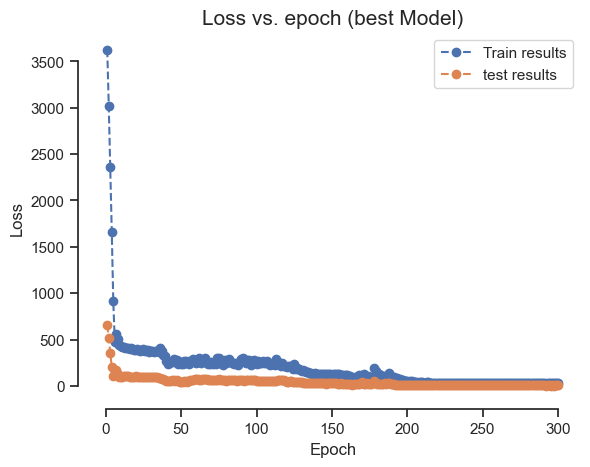

[660.1482696533203, 515.5366439819336, 360.1021041870117, 199.31141662597656, 103.25351333618164, 151.24321365356445, 171.50589752197266, 126.65850830078125, 100.32752990722656, 95.84031105041504, 96.64706802368164, 101.75308418273926, 106.40607070922852, 104.86996269226074, 103.0116958618164, 99.46328735351562, 97.82977104187012, 97.00721311569214, 99.55321502685547, 101.39865493774414, 100.40695190429688, 96.7064437866211, 93.73336791992188, 93.60363388061523, 93.49541091918945, 95.13894271850586, 97.84551239013672, 100.50210571289062, 96.14114761352539, 95.07959365844727, 91.77951049804688, 91.25716590881348, 91.14395904541016, 91.87200355529785, 87.012451171875, 81.09541702270508, 74.0767822265625, 68.97208786010742, 60.913065910339355, 56.446428298950195, 52.15689277648926, 54.050347328186035, 57.66275596618652, 65.50113868713379, 64.42082214355469, 57.033979415893555, 62.524702072143555, 49.571062088012695, 45.0866584777832, 44.7658805847168, 44.83869552612305, 47.83357620239258,

In [98]:
best_loss = None
plot("Loss vs. epoch (best Model)", "Loss", total_losses, test_total_losses, yscale='linear', extra_pt=best_loss, extra_pt_label="best loss")
print(test_total_losses)

In [ ]:
class Predictor(nn.Module):
    def __init__(self, vae_lstm, prediction_steps):
        super(Predictor, self).__init__()
        self.vae_lstm = vae_lstm
        self.prediction_steps = prediction_steps

    def forward(self, x):
        # Use the VAE LSTM to get the latent representation of the input
        _, mu, logvar = self.vae_lstm(x)

        # Use the latent representation to predict the next steps in the time series
        predictions = []
        for _ in range(self.prediction_steps):
            # Use the last prediction as input for the next prediction
            x, _, _ = self.vae_lstm(x)
            predictions.append(x)

        return torch.stack(predictions, dim=1)